# Cryptocurrency Tweets Project

# Importing Datasets and Packages

In [ ]:
# importing all the required Libraries
import glob
import json
import csv
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import calendar
import spacy #used spacy for text prepocessing

import gensim
from gensim import corpora

# libraries for visualization
!pip install pyLDAvis
import pyLDAvis
#import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Gemini Data Dictionary

Unix Timestamp - This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone

Date - This timestamp is converted to NY EST Standard Time

Symbol - The symbol for which the timeseries data refers (BITCOIN)

Open - This is the opening price of the time period

High - This is the highest price of the time period

Low - This is the lowest price of the time period

Close - This is the closing price of the time period

Volume - This is the volume in the transacted Ccy. Ie. For BTC/USD, this is in BTC amount

In [2]:
#Adding Gemini  hourly Bitcoin Data for outcome variable
gemini = pd.read_csv('/content/gemini_BTCUSD_1hr.csv')
gemini.head()
gemini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48153 entries, 0 to 48152
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unix Timestamp     48153 non-null  float64
 1   Date               48153 non-null  object 
 2   Date Without Time  48153 non-null  object 
 3   Time               48153 non-null  object 
 4   AM/PM              48153 non-null  object 
 5   Symbol             48153 non-null  object 
 6   Open               48153 non-null  float64
 7   High               48153 non-null  float64
 8   Low                48153 non-null  float64
 9   Close              48153 non-null  float64
 10  Volume             48153 non-null  float64
dtypes: float64(6), object(5)
memory usage: 4.0+ MB


In [3]:
#creating date time for Gemini info
gemini['Date'] = pd.to_datetime(gemini['Date'])

In [4]:
gemini.head() #Checking out how the data looks

,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume
0,1.620000e+12,2021-04-06,04-06-2021,12:00:00,AM,BTCUSD,59118.85,59429.91,59118.85,59208.04,12.501442
1,1.620000e+12,2021-04-05,04-05-2021,11:00:00,PM,BTCUSD,58877.38,59118.86,58590.19,59118.85,35.211204
2,1.620000e+12,2021-04-05,04-05-2021,10:00:00,PM,BTCUSD,58722.54,58993.00,58700.00,58877.38,19.949798
3,1.620000e+12,2021-04-05,04-05-2021,9:00:00,PM,BTCUSD,58819.59,58914.62,58530.31,58722.54,52.361956
4,1.620000e+12,2021-04-05,04-05-2021,8:00:00,PM,BTCUSD,59034.96,59102.00,58770.29,58819.59,40.449211


In [5]:
gemini.head()
#removing dates outside of the window for our crypto dataset (7/11/2018 to 7/20/2018)
gemini = gemini[gemini['Date'] < '2018-07-21'] #removing dates after the end of our window
gemini = gemini[gemini['Date'] > '2018-07-10'] #removing dates before start of our window
gemini.head()

,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume
23758,1.530000e+12,2018-07-20,07-20-2018,11:00:00,PM,BTCUSD,7354.78,7359.49,7324.76,7334.80,29.514704
23759,1.530000e+12,2018-07-20,07-20-2018,10:00:00,PM,BTCUSD,7297.65,7371.72,7280.00,7354.78,65.293686
23760,1.530000e+12,2018-07-20,07-20-2018,9:00:00,PM,BTCUSD,7351.32,7368.98,7297.65,7297.65,48.763541
23761,1.530000e+12,2018-07-20,07-20-2018,8:00:00,PM,BTCUSD,7345.00,7372.55,7324.48,7351.32,188.597967
23762,1.530000e+12,2018-07-20,07-20-2018,7:00:00,PM,BTCUSD,7357.12,7380.01,7295.14,7345.00,98.166342


In [6]:
#Calculating change in price by subtracting the hourly open price from the hourly close price
gemini['Price Change'] = gemini['Close'] - gemini['Open']
gemini.head()

,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume,Price Change
23758,1.530000e+12,2018-07-20,07-20-2018,11:00:00,PM,BTCUSD,7354.78,7359.49,7324.76,7334.80,29.514704,-19.98
23759,1.530000e+12,2018-07-20,07-20-2018,10:00:00,PM,BTCUSD,7297.65,7371.72,7280.00,7354.78,65.293686,57.13
23760,1.530000e+12,2018-07-20,07-20-2018,9:00:00,PM,BTCUSD,7351.32,7368.98,7297.65,7297.65,48.763541,-53.67
23761,1.530000e+12,2018-07-20,07-20-2018,8:00:00,PM,BTCUSD,7345.00,7372.55,7324.48,7351.32,188.597967,6.32
23762,1.530000e+12,2018-07-20,07-20-2018,7:00:00,PM,BTCUSD,7357.12,7380.01,7295.14,7345.00,98.166342,-12.12


In [7]:
#Assiging outcome signs for the price change. If price change > 0 then 1, otherwise 0
gemini_list = []

for price in gemini['Price Change']:
  if price > 0:
    gemini_list.append(1) #outcome is 1 if price change is greater than 0
  else:
    gemini_list.append(0) #if price does not change or decreases, outcome is 0
gemini['Outcome'] = gemini_list #attaching to the gemini list
gemini.head()  #we will assign outcomes to the time of tweets

,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume,Price Change,Outcome
23758,1.530000e+12,2018-07-20,07-20-2018,11:00:00,PM,BTCUSD,7354.78,7359.49,7324.76,7334.80,29.514704,-19.98,0
23759,1.530000e+12,2018-07-20,07-20-2018,10:00:00,PM,BTCUSD,7297.65,7371.72,7280.00,7354.78,65.293686,57.13,1
23760,1.530000e+12,2018-07-20,07-20-2018,9:00:00,PM,BTCUSD,7351.32,7368.98,7297.65,7297.65,48.763541,-53.67,0
23761,1.530000e+12,2018-07-20,07-20-2018,8:00:00,PM,BTCUSD,7345.00,7372.55,7324.48,7351.32,188.597967,6.32,1
23762,1.530000e+12,2018-07-20,07-20-2018,7:00:00,PM,BTCUSD,7357.12,7380.01,7295.14,7345.00,98.166342,-12.12,0


In [8]:
#Reading in the Cryptocurrency Tweets Dataset
df = pd.read_csv('/content/cleanprep.csv', names = ['Date', 'Date Without Time', 'Time', 'AM/PM', 'Twitter Username', 'Tweet Text', 'Tweet Text Polarity', 'Tweet Text Subjectivity'] )

In [9]:
df.head() # Read csv in with column names added, checking dataframe structure

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity
0,7/11/2018,07-11-2018,7:35:15,PM,b'tj',"b""Next two weeks prob v boring (climb up to 9k...",0.007273,0.590909
1,7/11/2018,07-11-2018,7:35:16,PM,b'Kool_Kheart',b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,0.000000,0.000000
2,7/11/2018,07-11-2018,7:35:16,PM,b'Gary Lang',b'Duplicate skilled traders automatically with...,0.625000,0.500000
3,7/11/2018,07-11-2018,7:35:16,PM,b'Jobs in Fintech',b'Project Manager - Technical - FinTech - Cent...,0.000000,0.175000
4,7/11/2018,07-11-2018,7:35:16,PM,b'ERC20',"b'Coinbase App Downloads Drop, Crypto Hype Fad...",0.333333,0.500000


In [10]:
#Checking the Ranges of Dates for Cryptocurrency Tweets
print(df['Date'].min())
print(df['Date'].max()) #date ranges from 7/11/2018 to 7/20/2018

7/11/2018
7/20/2018


Cryptocurrency Tweets Column Labels:
  - 1. Date: Date When Tweet was made
  - 2. Time: Time of Day Tweet was Made
  - 3. AM/PM: Whether Tweet was made in night or day
  - 4. Twitter Username: who made tweet
  - 5. Tweet Text: Text of Tweet
  - 6. Polarity
  - 7. Subjectivity

Potential Databases for BTC and other coin data (Use images for visual in project)

BTC: https://www.coindesk.com/price/bitcoin

LiteCoin: https://www.coindesk.com/price/litecoin


---


Ethereum: https://www.coindesk.com/price/ethereum

In [11]:
#Checking for Nulls
df.isnull().sum() #no null values

Date                       0
Date Without Time          0
Time                       0
AM/PM                      0
Twitter Username           0
Tweet Text                 0
Tweet Text Polarity        0
Tweet Text Subjectivity    0
dtype: int64

In [12]:
df[['Tweet Text Polarity','Tweet Text Subjectivity']].describe()
# polarity is emotion (-1 = negative, +1 = positive)
# subjectivity is subjectiveness (0 = very objective, 1 = very subjective)

,Tweet Text Polarity,Tweet Text Subjectivity
count,1.048575e+06,1.048575e+06
mean,9.807981e-02,2.142403e-01
std,2.391474e-01,2.956775e-01
min,-1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.363636e-01,4.200000e-01
max,1.000000e+00,1.000000e+00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Date                     1048575 non-null  object 
 1   Date Without Time        1048575 non-null  object 
 2   Time                     1048575 non-null  object 
 3   AM/PM                    1048575 non-null  object 
 4   Twitter Username         1048575 non-null  object 
 5   Tweet Text               1048575 non-null  object 
 6   Tweet Text Polarity      1048575 non-null  float64
 7   Tweet Text Subjectivity  1048575 non-null  float64
dtypes: float64(2), object(6)
memory usage: 64.0+ MB


# **Data Cleaning**

In [14]:
# import necessary packages
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
from textblob import TextBlob
import re # regex for text cleaning
import ast

 #### Regex Cleaning

In [15]:
# Clean Twitter Username by removing b' '
df['Twitter Username'] = df['Twitter Username'].apply(ast.literal_eval).str.decode("utf-8")

In [16]:
# Verify change
df.head()

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity
0,7/11/2018,07-11-2018,7:35:15,PM,tj,"b""Next two weeks prob v boring (climb up to 9k...",0.007273,0.590909
1,7/11/2018,07-11-2018,7:35:16,PM,Kool_Kheart,b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,0.000000,0.000000
2,7/11/2018,07-11-2018,7:35:16,PM,Gary Lang,b'Duplicate skilled traders automatically with...,0.625000,0.500000
3,7/11/2018,07-11-2018,7:35:16,PM,Jobs in Fintech,b'Project Manager - Technical - FinTech - Cent...,0.000000,0.175000
4,7/11/2018,07-11-2018,7:35:16,PM,ERC20,"b'Coinbase App Downloads Drop, Crypto Hype Fad...",0.333333,0.500000


In [17]:
# Clean Tweet text by removing b ' ' and b" ""
df['Tweet Text'] = df['Tweet Text'].apply(ast.literal_eval).str.decode("utf-8")

In [18]:
# Verify change
df.head()

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity
0,7/11/2018,07-11-2018,7:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909
1,7/11/2018,07-11-2018,7:35:16,PM,Kool_Kheart,@Miss_rinola But you’ve heard about BITCOIN?,0.000000,0.000000
2,7/11/2018,07-11-2018,7:35:16,PM,Gary Lang,Duplicate skilled traders automatically with B...,0.625000,0.500000
3,7/11/2018,07-11-2018,7:35:16,PM,Jobs in Fintech,Project Manager - Technical - FinTech - Centra...,0.000000,0.175000
4,7/11/2018,07-11-2018,7:35:16,PM,ERC20,"Coinbase App Downloads Drop, Crypto Hype Fadin...",0.333333,0.500000


In [19]:
#Dropping Duplicate Tweets
df.drop_duplicates(inplace=True, subset="Tweet Text")

In [20]:
#Verify Change
df.info() #46,911 duplicate rows dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001664 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Date                     1001664 non-null  object 
 1   Date Without Time        1001664 non-null  object 
 2   Time                     1001664 non-null  object 
 3   AM/PM                    1001664 non-null  object 
 4   Twitter Username         1001664 non-null  object 
 5   Tweet Text               1001664 non-null  object 
 6   Tweet Text Polarity      1001664 non-null  float64
 7   Tweet Text Subjectivity  1001664 non-null  float64
dtypes: float64(2), object(6)
memory usage: 68.8+ MB


Source for Code Cell (lemmatizer and tweet cleaner)
https://pub.towardsai.net/tweet-topic-modeling-part-2-cleaning-and-preprocessing-tweets-e3a08a8b1770

In [ ]:
#importing packages
import gensim
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'      # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

def tokenize_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['tokens'] = df.tweet.apply(preprocess_tweet)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [22]:
#clean tweets by looping through preprocess function

clean_tweets = []
for tweet in df['Tweet Text']:
  cleaned = preprocess_tweet(tweet)
  clean_tweets.append(cleaned)
df["Cleaned Tweet Texts"] = clean_tweets

In [23]:
df.head() #cleaning successful

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity,Cleaned Tweet Texts
0,7/11/2018,07-11-2018,7:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909,weeks prob bore climb new good list flip isn a...
1,7/11/2018,07-11-2018,7:35:16,PM,Kool_Kheart,@Miss_rinola But you’ve heard about BITCOIN?,0.000000,0.000000,hear bitcoin
2,7/11/2018,07-11-2018,7:35:16,PM,Gary Lang,Duplicate skilled traders automatically with B...,0.625000,0.500000,duplicate skilled traders automatically bitcoi...
3,7/11/2018,07-11-2018,7:35:16,PM,Jobs in Fintech,Project Manager - Technical - FinTech - Centra...,0.000000,0.175000,project manager technical fintech central lond...
4,7/11/2018,07-11-2018,7:35:16,PM,ERC20,"Coinbase App Downloads Drop, Crypto Hype Fadin...",0.333333,0.500000,coinbase app download drop crypto hype fade quick


In [24]:
#making the date column into datetime
df['Date'] = pd.to_datetime(df['Date'])
df.describe #datetime conversion successful
print(df.head())

        Date  ...                                Cleaned Tweet Texts
0 2018-07-11  ...  weeks prob bore climb new good list flip isn a...
1 2018-07-11  ...                                       hear bitcoin
2 2018-07-11  ...  duplicate skilled traders automatically bitcoi...
3 2018-07-11  ...  project manager technical fintech central lond...
4 2018-07-11  ...  coinbase app download drop crypto hype fade quick

[5 rows x 9 columns]


In [25]:
print(gemini.head())

       Unix Timestamp       Date  ... Price Change Outcome
23758    1.530000e+12 2018-07-20  ...       -19.98       0
23759    1.530000e+12 2018-07-20  ...        57.13       1
23760    1.530000e+12 2018-07-20  ...       -53.67       0
23761    1.530000e+12 2018-07-20  ...         6.32       1
23762    1.530000e+12 2018-07-20  ...       -12.12       0

[5 rows x 13 columns]


In [26]:
#Converting Gemini To Datetime and Extractign Hours

gemini['Time'] = pd.to_datetime(gemini['Time']) #converting to datetime
df['Time'] = pd.to_datetime(df['Time'])

hours = []
for x in gemini['Time']:
  hours.append(x.hour)
hours
gemini['Hour'] = hours
gemini.head() #creating column for gemini to extract hours


,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume,Price Change,Outcome,Hour
23758,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 11:00:00,PM,BTCUSD,7354.78,7359.49,7324.76,7334.80,29.514704,-19.98,0,11
23759,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 10:00:00,PM,BTCUSD,7297.65,7371.72,7280.00,7354.78,65.293686,57.13,1,10
23760,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 09:00:00,PM,BTCUSD,7351.32,7368.98,7297.65,7297.65,48.763541,-53.67,0,9
23761,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 08:00:00,PM,BTCUSD,7345.00,7372.55,7324.48,7351.32,188.597967,6.32,1,8
23762,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 07:00:00,PM,BTCUSD,7357.12,7380.01,7295.14,7345.00,98.166342,-12.12,0,7


In [27]:
#Extracting Hour from The Date Time
clone = pd.to_datetime(df['Time']) #creating a datetime version of df['Time']
#extracted hour


hours = []
for x in clone:
  hours.append(x.hour)
hours
df['Hour'] = hours
df.head() #creating column for df to extract hours

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity,Cleaned Tweet Texts,Hour
0,2018-07-11,07-11-2018,2021-04-29 07:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909,weeks prob bore climb new good list flip isn a...,7
1,2018-07-11,07-11-2018,2021-04-29 07:35:16,PM,Kool_Kheart,@Miss_rinola But you’ve heard about BITCOIN?,0.000000,0.000000,hear bitcoin,7
2,2018-07-11,07-11-2018,2021-04-29 07:35:16,PM,Gary Lang,Duplicate skilled traders automatically with B...,0.625000,0.500000,duplicate skilled traders automatically bitcoi...,7
3,2018-07-11,07-11-2018,2021-04-29 07:35:16,PM,Jobs in Fintech,Project Manager - Technical - FinTech - Centra...,0.000000,0.175000,project manager technical fintech central lond...,7
4,2018-07-11,07-11-2018,2021-04-29 07:35:16,PM,ERC20,"Coinbase App Downloads Drop, Crypto Hype Fadin...",0.333333,0.500000,coinbase app download drop crypto hype fade quick,7


In [28]:
#Describing the Date for Both Datasets
print(df['Date'].describe())
print(gemini['Date'].describe())

count                 1001664
unique                     10
top       2018-07-18 00:00:00
freq                   129271
first     2018-07-11 00:00:00
last      2018-07-20 00:00:00
Name: Date, dtype: object
count                     240
unique                     10
top       2018-07-19 00:00:00
freq                       24
first     2018-07-11 00:00:00
last      2018-07-20 00:00:00
Name: Date, dtype: object


In [29]:
gemini.head()

,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume,Price Change,Outcome,Hour
23758,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 11:00:00,PM,BTCUSD,7354.78,7359.49,7324.76,7334.80,29.514704,-19.98,0,11
23759,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 10:00:00,PM,BTCUSD,7297.65,7371.72,7280.00,7354.78,65.293686,57.13,1,10
23760,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 09:00:00,PM,BTCUSD,7351.32,7368.98,7297.65,7297.65,48.763541,-53.67,0,9
23761,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 08:00:00,PM,BTCUSD,7345.00,7372.55,7324.48,7351.32,188.597967,6.32,1,8
23762,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 07:00:00,PM,BTCUSD,7357.12,7380.01,7295.14,7345.00,98.166342,-12.12,0,7


In [30]:
df['Date'].head(1)

0   2018-07-11
Name: Date, dtype: datetime64[ns]

In [31]:
df['Date'].nsmallest(5)

0   2018-07-11
1   2018-07-11
2   2018-07-11
3   2018-07-11
4   2018-07-11
Name: Date, dtype: datetime64[ns]

In [32]:
df['Hour'].head(1)

0    7
Name: Hour, dtype: int64

In [33]:
df['AM/PM'].head(1)

0    PM
Name: AM/PM, dtype: object

In [34]:
gemini['Date'].head(1)

23758   2018-07-20
Name: Date, dtype: datetime64[ns]

In [35]:
gemini['Date'].nlargest(5)

23758   2018-07-20
23759   2018-07-20
23760   2018-07-20
23761   2018-07-20
23762   2018-07-20
Name: Date, dtype: datetime64[ns]

In [36]:
gemini['Hour'].head(1)

23758    11
Name: Hour, dtype: int64

In [37]:
gemini['AM/PM'].head(1)

23758    PM
Name: AM/PM, dtype: object

In [38]:
#Checking Datatypes
print(gemini.dtypes)
print(df.dtypes)

Unix Timestamp              float64
Date                 datetime64[ns]
Date Without Time            object
Time                 datetime64[ns]
AM/PM                        object
Symbol                       object
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume                      float64
Price Change                float64
Outcome                       int64
Hour                          int64
dtype: object
Date                       datetime64[ns]
Date Without Time                  object
Time                       datetime64[ns]
AM/PM                              object
Twitter Username                   object
Tweet Text                         object
Tweet Text Polarity               float64
Tweet Text Subjectivity           float64
Cleaned Tweet Texts                object
Hour                                int64
dtype: object


In [39]:
#Unsuccessful attempt to predict price by matching hours between dataframes

#adding outcome column to the df based on the Gemini Outcomes
#trying to match info from df date, hour and am/pm and then append gemini outcome from the 
#corresponding row to the tweets

#gemini_outcomes = []
#df = df.reset_index(drop=True)
#gemini = gemini.reset_index(drop=True)
#for row in df:
  #for line in gemini:
    #if str(gemini['Date Without Time'][line.index]) == str(df['Date Without Time'][row.index]):
     # if str(gemini['Hour'][line.index]) == str(df['Hour'][row.index]):
     #   if str(gemini['AM/PM'][line.index]) == str(df['AM/PM'][row.index]):
 # if (gemini['Date Without Time'] == df['Date Without Time'] and gemini['Hour'] == df['Hour'] and gemini['AM/PM'] == df['AM/PM']):
    #if gemini['Hour'] == df['Hour']:
     # if gemini['AM/PM'] == df['AM/PM']:
         # gemini_outcomes.append(gemini['Outcome'])

#gemini_outcomes


In [40]:
gemini.head(1)

,Unix Timestamp,Date,Date Without Time,Time,AM/PM,Symbol,Open,High,Low,Close,Volume,Price Change,Outcome,Hour
23758,1.530000e+12,2018-07-20,07-20-2018,2021-04-29 11:00:00,PM,BTCUSD,7354.78,7359.49,7324.76,7334.8,29.514704,-19.98,0,11


In [41]:
df.head(1)

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity,Cleaned Tweet Texts,Hour
0,2018-07-11,07-11-2018,2021-04-29 07:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909,weeks prob bore climb new good list flip isn a...,7


# EDA Graphs
#### Word Clouds, Histograms, Etc.

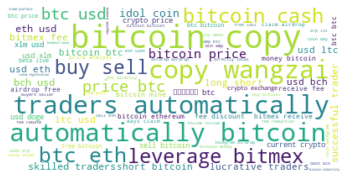

In [42]:
#Word Cloud, all words from Cleaned text
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# concatenate all the reviews into one single string 
full_text = ' '.join(df['Cleaned Tweet Texts'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

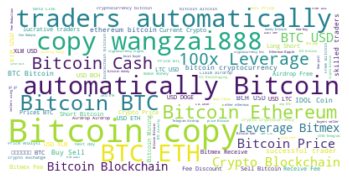

In [43]:
#Word Cloud, all words from old text
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# concatenate all the reviews into one single string 
full_text = ' '.join(df['Tweet Text'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


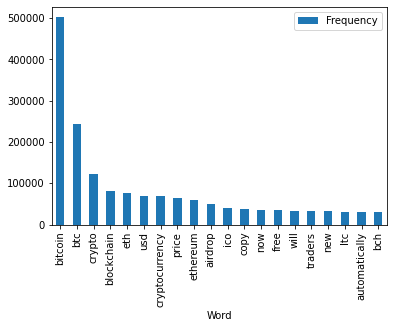

In [44]:
#Cleaned Text Frequency Chart
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import FreqDist

lower_full_text = full_text.lower()
word_tokens = word_tokenize(lower_full_text)
tokens = list()
for word in word_tokens:
    if word.isalpha() and word not in my_stop_words:
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist.plot.bar(x='Word',y='Frequency')

#Bitcoin, Crypto, and Blockchain are most frequent words

In [45]:
df.head(1)

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity,Cleaned Tweet Texts,Hour
0,2018-07-11,07-11-2018,2021-04-29 07:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909,weeks prob bore climb new good list flip isn a...,7


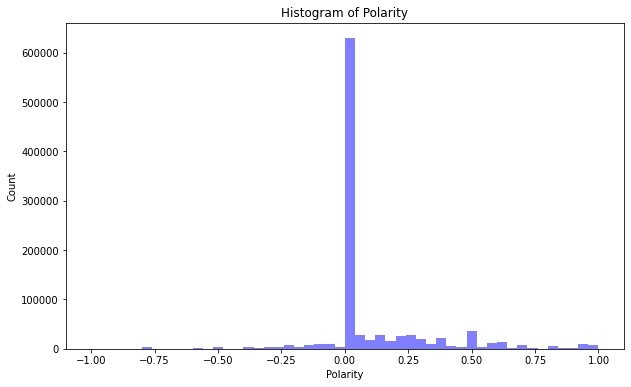

In [46]:
#Draw a histogram that shows the distribution of polarity: Count vs. polarity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df['Tweet Text Polarity'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

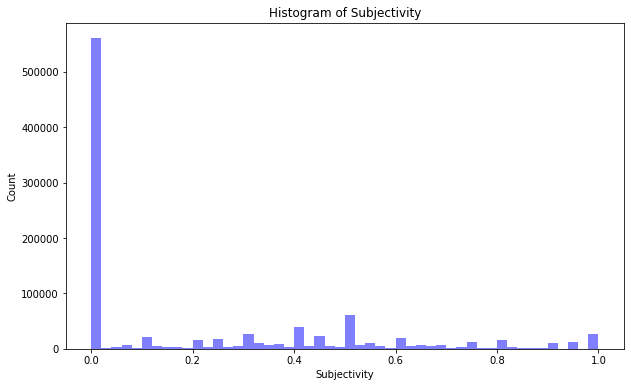

In [47]:
#Draw a histogram that shows the distribution of Subjectivity: Count vs. Subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df['Tweet Text Subjectivity'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjectivity')
plt.show() #very objective, is this because it's a tweet or if subject matter is objective?

#LDA / Topic Modeling

In [48]:
df.head(1)

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity,Cleaned Tweet Texts,Hour
0,2018-07-11,07-11-2018,2021-04-29 07:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909,weeks prob bore climb new good list flip isn a...,7


In [49]:
# create new columns for polarity and subjectivity of the cleaned tweets using the cleaned text
df['cleaned_polarity'] = df['Cleaned Tweet Texts'].apply(lambda x: TextBlob(x).sentiment[0])
df['cleaned_subjectivity'] = df['Cleaned Tweet Texts'].apply(lambda x: TextBlob(x).sentiment[1])

In [50]:
df.head(1)

,Date,Date Without Time,Time,AM/PM,Twitter Username,Tweet Text,Tweet Text Polarity,Tweet Text Subjectivity,Cleaned Tweet Texts,Hour,cleaned_polarity,cleaned_subjectivity
0,2018-07-11,07-11-2018,2021-04-29 07:35:15,PM,tj,Next two weeks prob v boring (climb up to 9k) ...,0.007273,0.590909,weeks prob bore climb new good list flip isn a...,7,0.345455,0.651515


In [51]:
df.dtypes

Date                       datetime64[ns]
Date Without Time                  object
Time                       datetime64[ns]
AM/PM                              object
Twitter Username                   object
Tweet Text                         object
Tweet Text Polarity               float64
Tweet Text Subjectivity           float64
Cleaned Tweet Texts                object
Hour                                int64
cleaned_polarity                  float64
cleaned_subjectivity              float64
dtype: object

In [52]:
#Inspecting New Cleaned Polarity Column
df['cleaned_polarity'].describe()

count    1.001664e+06
mean     7.567888e-02
std      2.258558e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: cleaned_polarity, dtype: float64

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [54]:
# this function will return cv, dtm and LDA given a dataset
def get_cv_dtm_lda(df, num_comp=5):
  reviews = df['Cleaned Tweet Texts'] #for some reason this works with the uncleaned text, but not the cleaned text
  cv = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
  dtm = cv.fit_transform(reviews)
  LDA = LatentDirichletAllocation(n_components=num_comp, random_state=42)
  LDA.fit(dtm)
  return cv, dtm, LDA

# this function will return the top n words in each topic
def get_top_words(LDAcomps, cv, ptype, n=15):
  m = n-2*n
  print(ptype)
  for index, topic in enumerate(LDAcomps):
    print(f'The top {n} words for topic #{index}')
    print([cv.get_feature_names()[index] for index in topic.argsort()[m:]])
    print('\n')

In [55]:
#Reduce size of the negative and positive datasets
# take top 5000 positive 
#take top 5000 most negative

#we can do this for positive and negative tweets based on polarity
# divide dataset into positive and negative tweets based on cleaned_polarity
positive_tweets_df = df[df['cleaned_polarity']>=0].nlargest(5000, columns= 'cleaned_polarity')
#pos_ dicto = corpora.Dictionary(positive_tweets_df['Cleaned Tweet Texts'])
negative_tweet_df = df[df['cleaned_polarity']<0].nsmallest(5000, columns= 'cleaned_polarity')
#neg_dicto = corpora.Dictionary(negative_tweet_df['Cleaned Tweet Texts'])

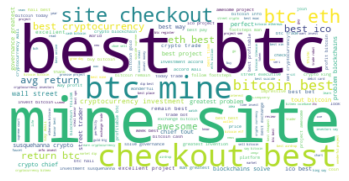

In [56]:
#Positive Tweets Word Cloud 

# concatenate all the reviews into one single string 
full_text = ' '.join(positive_tweets_df['Cleaned Tweet Texts'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

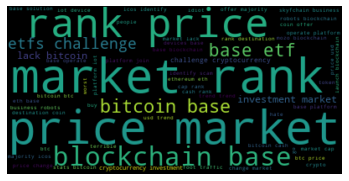

In [57]:
#Negative Tweets Word Cloud

# concatenate all the reviews into one single string 
full_text = ' '.join(negative_tweet_df['Cleaned Tweet Texts'])

my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
cloud_no_stopword = WordCloud(background_color='black', stopwords=my_stop_words).generate(full_text)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

In [58]:
#Preparing the Topic Modeling
positive_tweet_cv, positive_tweet_dtm, positive_tweet_LDA = get_cv_dtm_lda(positive_tweets_df)
negative_tweet_cv, negative_tweet_dtm, negative_tweet_LDA = get_cv_dtm_lda(negative_tweet_df)

In [59]:
get_top_words(positive_tweet_LDA.components_, positive_tweet_cv, 'Positive Tweets')

Positive Tweets
The top 15 words for topic #0
['thank', 'executive', 'miss', 'list', 'card', 'ethereum', 'exchange', 'pay', 'sit', 'earn', 'bitcoin', 'checkout', 'site', 'btc', 'best']


The top 15 words for topic #1
['platform', 'wonderful', 'profit', 'crypto', 'like', 'time', 'info', 'today', 'market', 'trade', 'way', 'invest', 'perfect', 'bitcoin', 'best']


The top 15 words for topic #2
['say', 'exchange', 'bet', 'buy', 'trader', 'tout', 'susquehanna', 'chief', 'street', 'wall', 'investment', 'crypto', 'cryptocurrency', 'best', 'bitcoin']


The top 15 words for topic #3
['blockchain', 'team', 'blockchains', 'join', 'solve', 'governance', 'problem', 'trade', 'crypto', 'greatest', 'excellent', 'awesome', 'ico', 'project', 'best']


The top 15 words for topic #4
['ltc', 'year', 'moac', 'company', 'impressive', 'coinbase', 'btg', 'world', 'xin', 'pay', 'avg', 'return', 'eth', 'btc', 'best']




In [60]:
get_top_words(negative_tweet_LDA.components_, negative_tweet_cv, 'Negative Tweets')

Negative Tweets
The top 15 words for topic #0
['offer', 'scam', 'change', 'cap', 'btc', 'lack', 'challenge', 'etfs', 'investment', 'base', 'cryptocurrency', 'bitcoin', 'price', 'market', 'rank']


The top 15 words for topic #1
['currency', 'profit', 'build', 'evil', 'world', 'eth', 'need', 'exchange', 'crypto', 'blockchain', 'ethereum', 'coin', 'btc', 'bitcoin', 'base']


The top 15 words for topic #2
['thingschain', 'company', 'cryptocurrency', 'btc', 'launch', 'join', 'trade', 'bitcoin', 'skyfchain', 'robots', 'operate', 'business', 'platform', 'blockchain', 'base']


The top 15 words for topic #3
['increase', 'venues', 'foot', 'amp', 'project', 'traffic', 'idiot', 'mozo', 'retailers', 'cryptocurrency', 'platform', 'bitcoin', 'solution', 'blockchain', 'base']


The top 15 words for topic #4
['money', 'think', 'people', 'worthless', 'buy', 'insane', 'crypto', 'usd', 'cash', 'trend', 'hate', 'worst', 'base', 'btc', 'bitcoin']




In [ ]:
!pip install spacy download en_core_web_sm

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:
text_list=positive_tweets_df['Cleaned Tweet Texts'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

In [64]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [ ]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [66]:
#Printing LDA Analysis Topics 
lda_model.print_topics()

[(0,
  '0.185*"great" + 0.109*"problem" + 0.080*"solve" + 0.035*"man" + 0.034*"good" + 0.030*"invention" + 0.030*"footstep" + 0.021*"world" + 0.016*"life" + 0.013*"story"'),
 (1,
  '0.099*"market" + 0.098*"time" + 0.081*"good" + 0.044*"impressive" + 0.027*"price" + 0.022*"team" + 0.015*"perfect" + 0.015*"buy" + 0.014*"benefit" + 0.013*"platform"'),
 (2,
  '0.179*"good" + 0.099*"trade" + 0.079*"exchange" + 0.079*"bitcoin" + 0.053*"profit" + 0.042*"week" + 0.033*"cryptocurrency" + 0.020*"currency" + 0.018*"service" + 0.018*"crypto"'),
 (3,
  '0.114*"good" + 0.112*"perfect" + 0.069*"wonderful" + 0.051*"bot" + 0.050*"trade" + 0.036*"project" + 0.033*"online" + 0.028*"profitable" + 0.023*"news" + 0.016*"industry"'),
 (4,
  '0.412*"good" + 0.160*"cryptocurrency" + 0.134*"investment" + 0.034*"trader" + 0.025*"airdrop" + 0.014*"choice" + 0.012*"guy" + 0.011*"option" + 0.009*"pro" + 0.007*"opportunity"'),
 (5,
  '0.145*"good" + 0.072*"investor" + 0.060*"bet" + 0.052*"trader" + 0.030*"cryptocurr

In [67]:
#For Positive Tweets top 5000
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.095308 -0.203554       1        1  17.019999
9     -0.132556  0.090534       2        1  15.767301
7     -0.092578  0.107346       3        1  10.669631
4     -0.106169  0.106660       4        1  10.113114
6     -0.028823 -0.175242       5        1   8.429334
2     -0.070895  0.113038       6        1   8.370627
3      0.024900 -0.125212       7        1   8.323017
0      0.363760  0.080564       8        1   8.032514
1      0.119137 -0.094145       9        1   7.133348
5      0.018531  0.100011      10        1   6.141115, topic_info=               Term        Freq        Total Category  logprob  loglift
208            mine  576.000000   576.000000  Default  30.0000  30.0000
288            site  551.000000   551.000000  Default  29.0000  29.0000
146             btc  544.000000   544.000000  Default  28.0000  28.0000
38          bitcoin  452.000000   452.000000  Default  27.0000  27.0000
62            great  252.000000   252.000000  Default  26.0000  26.0000
..              ...         ...          ...      ...      ...      ...
7            trader   54.432902   113.659992  Topic10  -2.9525   2.0539
0              good  151.172658  3143.816334  Topic10  -1.9311  -0.2446
5    cryptocurrency   30.941837   354.084465  Topic10  -3.5174   0.3527
298           world    9.334683    38.053338  Topic10  -4.7158   1.3849
221           month    7.527931    23.674649  Topic10  -4.9309   1.6444

[388 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
468       8  0.826833       access
129       4  0.949861       accord
299       5  0.926438      account
1173      7  0.916051  achievement
824       8  0.890695       advice
...     ...       ...          ...
27        7  0.988714    wonderful
237       1  0.974195         work
298       8  0.735809        world
298      10  0.236510        world
320       1  0.969235         year

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 8, 5, 7, 3, 4, 1, 2, 6])

In [ ]:
#Repeating the Process for Negative Tweets
text_list=negative_tweet_df['Cleaned Tweet Texts'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

In [69]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [ ]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [71]:
#Printing Topics
lda_model.print_topics()

[(0,
  '0.109*"base" + 0.107*"bitcoin" + 0.039*"finance" + 0.033*"transaction" + 0.029*"project" + 0.023*"evaluation" + 0.023*"proposal" + 0.020*"fight" + 0.018*"insane" + 0.015*"week"'),
 (1,
  '0.102*"launch" + 0.069*"base" + 0.068*"worthless" + 0.021*"maker" + 0.021*"fraud" + 0.020*"work" + 0.020*"truedigital" + 0.018*"index" + 0.018*"line" + 0.016*"violent"'),
 (2,
  '0.144*"change" + 0.127*"market" + 0.116*"rank" + 0.110*"cap" + 0.043*"idiot" + 0.030*"user" + 0.029*"btc" + 0.020*"evil" + 0.009*"bear" + 0.008*"large"'),
 (3,
  '0.118*"base" + 0.057*"scam" + 0.052*"retailer" + 0.045*"traffic" + 0.043*"foot" + 0.042*"solution" + 0.039*"venue" + 0.036*"token" + 0.027*"control" + 0.023*"design"'),
 (4,
  '0.109*"trend" + 0.101*"cash" + 0.069*"usd" + 0.065*"price" + 0.056*"rank" + 0.051*"stat" + 0.028*"volume" + 0.021*"use" + 0.019*"origin" + 0.018*"horrible"'),
 (5,
  '0.320*"price" + 0.317*"market" + 0.313*"rank" + 0.004*"technolo" + 0.002*"buy" + 0.002*"sell" + 0.002*"skyft" + 0.002*

In [72]:
#For Negative Tweets top 5000
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.399331 -0.103574       1        1  31.178470
7      0.188986 -0.202671       2        1  13.685578
8     -0.008143 -0.209401       3        1  10.876778
9      0.066358  0.184993       4        1   7.234896
0      0.159315 -0.021235       5        1   6.864242
3      0.164592 -0.055601       6        1   6.631038
1      0.145377  0.016579       7        1   6.568425
2     -0.231553 -0.001543       8        1   5.858809
4     -0.145281  0.149756       9        1   5.634982
6      0.059681  0.242696      10        1   5.466782, topic_info=            Term         Freq        Total Category  logprob  loglift
6          price  1643.000000  1643.000000  Default  30.0000  30.0000
550         rank  1708.000000  1708.000000  Default  29.0000  29.0000
33        market  1906.000000  1906.000000  Default  28.0000  28.0000
532         base   987.000000   987.000000  Default  27.0000  27.0000
520   blockchain   285.000000   285.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
40         world    16.932072    20.854603  Topic10  -3.9366   2.6981
1224  preference     3.794625     4.679190  Topic10  -5.4322   2.6969
433        twitt     3.790394     4.674941  Topic10  -5.4333   2.6967
780    goverment     3.593986     4.478524  Topic10  -5.4865   2.6864
949         sale    15.788612    20.424135  Topic10  -4.0065   2.6491

[383 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
779       2  0.852709        actifs
689       6  0.884472      activity
149       6  0.208887         actor
149       8  0.626660         actor
824       2  0.948074      adoption
...     ...       ...           ...
596       7  0.988609     worthless
1139      4  0.861105       xchange
77        2  0.336524          year
77        4  0.630982          year
640       4  0.972783  アメリカでsec承認済み

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 9, 10, 1, 4, 2, 3, 5, 7])

#GloVe and Document Clustering

In [ ]:
spacy.cli.download("en_vectors_web_lg")

import spacy

nlp = spacy.load("en_vectors_web_lg")

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

In [ ]:
#Runing GloVe on the positive tweets dataframe
unique_words = list(set([word for sublist in [doc.split() for doc in positive_tweets_df['Cleaned Tweet Texts']] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/

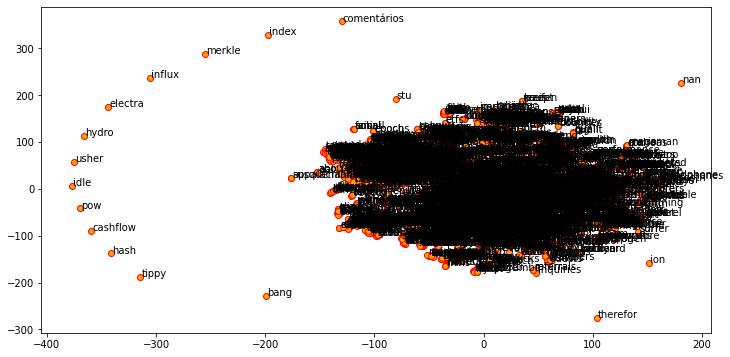

In [75]:
from sklearn.manifold import TSNE

#Graphing the positive tweets df
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
#Using K-means to cluster the documents in the positive tweets df
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in positive_tweets_df['Cleaned Tweet Texts']])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([positive_tweets_df['Cleaned Tweet Texts'], cluster_labels], axis=1)

In [ ]:
#Repeating with Negative Tweets Df
#Runing GloVe on the Negative tweets dataframe
unique_words = list(set([word for sublist in [doc.split() for doc in negative_tweet_df['Cleaned Tweet Texts']] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)


In [ ]:
from sklearn.manifold import TSNE

#Graphing the Negative tweets df
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
#Using K-means to cluster the documents in the Negative tweets df
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in negative_tweet_df['Cleaned Tweet Texts']])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([negative_tweet_df['Cleaned Tweet Texts'], cluster_labels], axis=1)

### Sentiment Analysis on Logistic Regression and Naive Bayes


In [80]:
positive_tweets_df = df[df['cleaned_polarity']>=0].nlargest(5000, columns= 'cleaned_polarity')
negative_tweet_df = df[df['cleaned_polarity']<0].nsmallest(5000, columns= 'cleaned_polarity')
positive_tweets_df.head()

test_pos = positive_tweets_df['Cleaned Tweet Texts'][4000:]
train_pos = positive_tweets_df['Cleaned Tweet Texts'][:4000]
test_neg = negative_tweet_df['Cleaned Tweet Texts'][4000:]
train_neg = negative_tweet_df['Cleaned Tweet Texts'][:4000]

train_x = train_pos.append(train_neg)
test_x = test_pos.append(test_neg)


In [81]:
test_pos = positive_tweets_df['cleaned_polarity'][4000:]
train_pos = positive_tweets_df['cleaned_polarity'][:4000]
test_neg = negative_tweet_df['cleaned_polarity'][4000:]
train_neg = negative_tweet_df['cleaned_polarity'][:4000]

train_y = train_pos.append(train_neg)
test_y = test_pos.append(test_neg)
train_y = pd.DataFrame([1 if x > 0 else 0 for x in train_y])
test_y = pd.DataFrame([1 if x > 0 else 0 for x in test_y])

In [82]:
train_y.value_counts()

0    4000
1    4000
dtype: int64

In [83]:
test_y.value_counts()

0    1000
1    1000
dtype: int64

In [84]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import nltk
import re
import string
nltk.download('stopwords')
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [85]:
# Create a frequency dictionary function

def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [86]:
freq_x = []
for tweet in train_x:
  finished = process_tweet(tweet)
  freq_x.append(finished)

In [87]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 5157


In [88]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    # calculate the sigmoid of z
    h = 1/(1 + np.exp(-z))
    
    return h

In [89]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    
    m = len(x)
  
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m)*(np.dot(y.T,np.log(h)) + np.dot((1-y).T,np.log(1-h)))
        
        # update the weights theta
        theta = theta - (alpha/m)*np.dot(x.T, h-y)
        
    J = float(J)
    return J, theta

In [90]:
#defining feature extraction
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
        
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)
        
    assert(x.shape == (1, 3))
    return x

In [91]:
train_x.shape

(8000,)

In [92]:
train_x.head()

51                                              best ico
95         sales consultant comp best buy costa mesa usa
145                                  digest best airdrop
153    bitcoin remain best cryptocurrency investment ...
358                 isn best page crypto update facebook
Name: Cleaned Tweet Texts, dtype: object

In [93]:
#Have to reset indexes for the function to work
train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [ ]:
# collect the features 'x' and stack them into a matrix 'X' #had too many issues running this code
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
   X[i, :] = extract_features(train_x[i], freqs)
# training labels corresponding to X
X = train_x
Y = train_y
# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((8000,3)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

In [95]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    z = np.dot(x,theta)
    y_pred = sigmoid(z)
    
    
    return y_pred
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
        
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)
# With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    y_hat = np.array(y_hat)
    test_y = test_y.reshape(-1)
    accuracy = np.sum((test_y == y_hat).astype(int))/len(test_x)
    
    return accuracy

In [96]:
npx = test_x.to_numpy() #have to convert to numpy to have the code work

In [97]:
npy = test_y.to_numpy()

In [ ]:
logistic_model_accuracy = test_logistic_regression(test_x, npy, freqs, theta)

In [ ]:
print(logistic_model_accuracy)

In [ ]:
#Naive Bayes Portion

In [100]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get(pair, 1)
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get(pair, 1)
    # Calculate D, the number of documents
    D = len(train_y)
    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = sum(train_y)
    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D-D_pos
    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1),0)
        freq_neg = freqs.get((word, 0),0)
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
    return logprior, loglikelihood
    logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

In [101]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
'''
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)
# initialize probability to zero
    p = 0
# add the logprior
    p += logprior
    for word in word_l:
# check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]
    return p


In [102]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly
y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0
# append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    
    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats - test_y))
# Accuracy is 1 minus the error
    accuracy = 1 - error
return accuracy

IndentationError: ignored

In [103]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

In [ ]:
test_naive_bayes(test_x, npy, logprior, loglikelihood) #unusual and weak results, pretty much a random guess for both models with this code

In [ ]:
test_y.value_counts()

#Naive Bayes and Logistic Regression

In [105]:
# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [106]:
# fit and transform X_train into X_train_dtm
# to get the DTM
X_train_dtm = vect.fit_transform(train_x)
X_train_dtm.shape

(8000, 4555)

In [107]:
X_test_dtm = vect.transform(test_x)
X_test_dtm.shape

(2000, 4555)

In [108]:
# import/instantiate/fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [109]:
nb.predict_proba(X_test_dtm)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.0000015 , 0.9999985 ],
       ...,
       [0.99999931, 0.00000069],
       [0.99999931, 0.00000069],
       [0.9999627 , 0.0000373 ]])

In [110]:
#class predictions

pred_y = nb.predict(X_test_dtm)

In [111]:
# calculate the predicted probability of positive=1 for each testing set observation
#now i want all rows and only the 2nd column (positive column) by using [:, 1]
nb.predict_proba(X_test_dtm)[:, 1]

array([1.        , 1.        , 0.9999985 , ..., 0.00000069, 0.00000069,
       0.0000373 ])

In [114]:
y_pred_prob= nb.predict_proba(X_test_dtm)[:, 1]

In [113]:
#calculate the AUC
from sklearn import metrics
metrics.roc_auc_score(test_y, y_pred_prob)

0.9995529999999999

In [115]:
#calculate the accuracy
metrics.accuracy_score(test_y,pred_y)

0.9925

In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [117]:
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

[[993   7]
 [  8 992]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [118]:
#Repeating with Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_dtm, train_y)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
pred_y_log = logreg.predict(X_test_dtm)
print(metrics.roc_auc_score(test_y, y_pred_prob))
print(metrics.accuracy_score(test_y, pred_y_log))

0.9999910000000001
0.997


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:295: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [119]:
print(confusion_matrix(test_y, pred_y_log))
print(classification_report(test_y, pred_y_log))

[[1000    0]
 [   6  994]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

